In [ ]:
!mkdir ./code/microservice_01
%cd ./code/microservice_01

/content/reco-tut-k8s/code/microservice_01


## Creating a trivial Node.js app

It should be clear what this code does. It starts up an HTTP server on port 8080. The server responds with an HTTP response status code 200 OK and the text "You've hit <hostname>" to every request. The request handler also logs the client’s IP address to the standard output, which you’ll need later. The returned hostname is the server’s actual hostname, not the one the client sends in the HTTP request’s Host header.

In [ ]:
%%writefile app.js
const http = require('http');
const os = require('os');

console.log("Kubia server starting...");

var handler = function(request, response) {
  console.log("Received request from " + request.connection.remoteAddress);
  response.writeHead(200);
  response.end("You've hit " + os.hostname() + "\n");
};

var www = http.createServer(handler);
www.listen(8080);

Writing app.js


## Creating a Dockerfile for the image
To package your app into an image, you first need to create a file called Dockerfile, which will contain a list of instructions that Docker will perform when building the image. The Dockerfile needs to be in the same directory as the app.js file and should contain the commands shown in the following listing.

In [ ]:
%%writefile Dockerfile
FROM node:7
ADD app.js /app.js
ENTRYPOINT ["node", "app.js"]

Writing Dockerfile


## Building the container image
Now that you have your Dockerfile and the app.js file, you have everything you need to build your image. To build it, run the following Docker command:

In [ ]:
%%writefile 01_build_image.sh
docker build -t kubia .

Writing 01_build_image.sh


You’re telling Docker to build an image called kubia based on the contents of the current directory (note the dot at the end of the build command). Docker will look for the Dockerfile in the directory and build the image based on the instructions in the file.

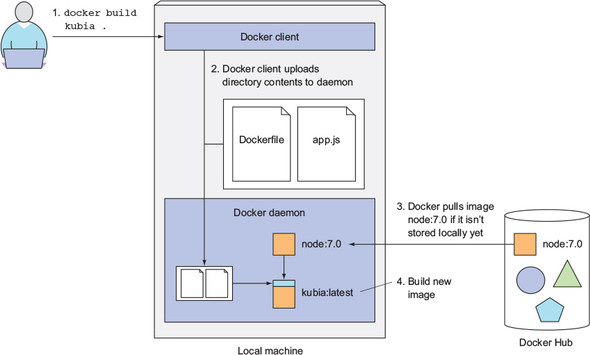

The build process isn’t performed by the Docker client. Instead, the contents of the whole directory are uploaded to the Docker daemon and the image is built there. The client and daemon don’t need to be on the same machine at all. If you’re using Docker on a non-Linux OS, the client is on your host OS, but the daemon runs inside a VM. Because all the files in the build directory are uploaded to the daemon, if it contains many large files and the daemon isn’t running locally, the upload may take longer.

> Tip: You can see the list of locally-stored docker images by running ```$ docker images``` command.

> Note: Container images are composed of layers that can be shared among different images.

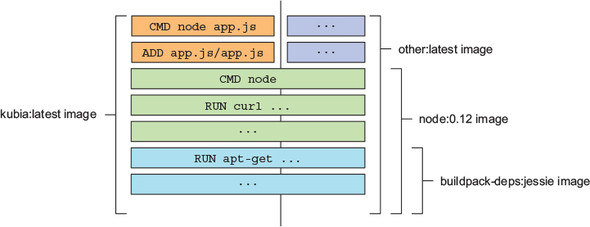

## Running the container image
You can now run your image with the following command:

In [ ]:
%%writefile 02_run_container.sh
docker run --name kubia-container -p 8080:8080 -d kubia

Writing 02_run_container.sh


This tells Docker to run a new container called kubia-container from the kubia image. The container will be detached from the console (-d flag), which means it will run in the background. Port 8080 on the local machine will be mapped to port 8080 inside the container (-p 8080:8080 option), so you can access the app through http://localhost:8080.

## Push the image to Dockerhub

In [ ]:
%%writefile 03_push_image.sh
docker tag kubia:latest sparshai/kubia:latest
docker push sparshai/kubia

Writing 03_push_image.sh


## Docker commands
Here are some handy commands:
- ```$ curl localhost:8080``` for accessing your app.
- ```$ docker ps``` for listing all the running containers.
- ```$ docker inspect kubia-container``` for more detailed information
- ```$ docker exec -it kubia-container bash``` for starting docker shell
- ```$ ps aux``` for listing running processes inside docker
- ```$ docker stop kubia-container``` for stopping the container
- ```$ docker rm kubia-container``` for deleting the container
- ```$ docker push <your-id>/kubia``` for pushing image to DockerHub.

## Running the image on a different machine
After the push to Docker Hub is complete, the image will be available to everyone. You can now run the image on any machine running Docker by executing the following command: ```$ docker run -p 8080:8080 -d luksa/kubia```.

It doesn’t get much simpler than that. And the best thing about this is that your application will have the exact same environment every time and everywhere it’s run. If it ran fine on your machine, it should run as well on every other Linux machine. No need to worry about whether the host machine has Node.js installed or not. In fact, even if it does, your app won’t use it, because it will use the one installed inside the image.

## Kubernetes commands
Here are some handy commands:
- ```$ kubectl get nodes``` for listing cluster nodes
- ```$ kubectl describe node xxx-kubia-85f6-node-0rrx``` for retrieving additional details of an object
- ```$ alias k=kubectl``` to create alias for kubectl command
- ```$ kubectl get pods``` for listing pods
- ```$ kubectl get services``` for listing services

## Start the cluster
First step is to initialize the cluster in the first terminal:

In [ ]:
%%writefile 04_start_cluster.sh
kubeadm init --apiserver-advertise-address $(hostname -i)

Writing 04_start_cluster.sh


That means you’re almost ready to go. Last you just have to initialize your cluster networking in the first terminal:

In [ ]:
%%writefile 05_enable_networking.sh
kubectl apply -n kube-system -f "https://cloud.weave.works/k8s/net?k8s-version=$(kubectl version | base64 |tr -d '\n')"

Writing 05_enable_networking.sh


To join other nodes as workers to the master node, run command like the following that you will receive from the master terminal after starting the cluster.

```
kubeadm join 192.168.0.33:6443 --token 20l5u8.pekij3hq5xzux7h9 \
    --discovery-token-ca-cert-hash sha256:572d36c75cd7456302c44886f4ae99514956c99cef3db7a50be7ed78080f5a77
```

## Deploying your Node.js app
The simplest way to deploy your app is to use the kubectl run command, which will create all the necessary components without having to deal with JSON or YAML. This way, we don’t need to dive into the structure of each object yet. Try to run the image you created and pushed to Docker Hub earlier. Here’s how to run it in Kubernetes:

In [ ]:
%%writefile 06_deploy_app.sh
kubectl create deployment kubia-app --image=sparshai/kubia --port=8080

Writing 06_deploy_app.sh


> Tip: Check the status by running ```$ k get pods``` or ```$ k describe pods``` for more detailed info.

## Behind the scenes

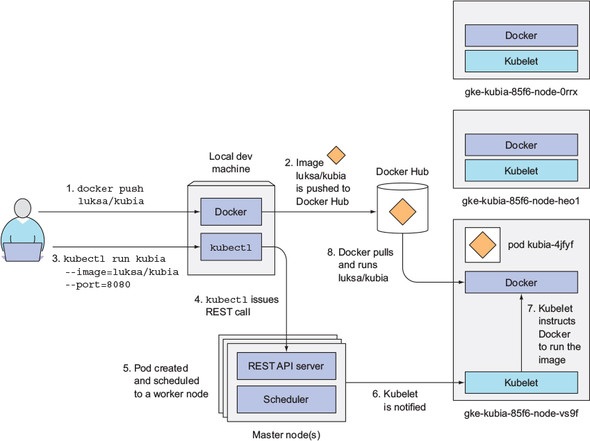

## Accessing your web application
With your pod running, how do you access it? We mentioned that each pod gets its own IP address, but this address is internal to the cluster and isn’t accessible from outside of it. To make the pod accessible from the outside, you’ll expose it through a Service object. You’ll create a special service of type LoadBalancer, because if you create a regular service (a ClusterIP service), like the pod, it would also only be accessible from inside the cluster. By creating a LoadBalancer-type service, an external load balancer will be created and you can connect to the pod through the load balancer’s public IP.

To create the service, you’ll tell Kubernetes to expose the ReplicationController you created earlier:

In [ ]:
%%writefile 07_run_service.sh
kubectl expose deployment kubia-app --type LoadBalancer --port 80 --target-port 8080

Writing 07_run_service.sh


> Tip: ```k get services``` to get list of running services.